In [1]:
import pandas as pd
import glob
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os

In [3]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Define the list of training files
train_files = ['/kaggle/input/kaggle-stock-market-prediction/1_train.csv',
 '/kaggle/input/kaggle-stock-market-prediction/4_train.csv',
'/kaggle/input/kaggle-stock-market-prediction/3_train.csv',
'/kaggle/input/kaggle-stock-market-prediction/2_train.csv']
# Create an empty dictionary to store the models
models = {}


# Loop through each training file
for file in train_files:
    # Load the training data
    train_data = pd.read_csv(file)
    print(train_data.head())
#     print(train_data.shape)

         Date  Open  High   Low  Close  Adj Close        Volume
0  2010-06-29  9.50  9.47  9.23   9.12       7.93  1.133345e+09
1  2010-06-30  9.25  9.22  9.00   9.04       7.52  7.394520e+08
2  2010-07-01  9.01  9.02  8.63   8.70       7.45  1.022896e+09
3  2010-07-02  8.98  8.96  8.74   8.94       7.68  6.938428e+08
4  2010-07-06  9.13  9.13  8.61   8.85       7.68  6.152356e+08
         Date  Open  High   Low  Close  Adj Close       Volume
0  29-06-2010  1.05  1.67  1.24   1.55       1.64  281494500.0
1  30-06-2010  1.64  2.02  1.56   1.69       1.69  257806500.0
2  01-07-2010  1.85  1.83  1.24   1.43       1.26  123282000.0
3  02-07-2010  1.56  1.59  1.18   1.46       1.27   77097000.0
4  06-07-2010  1.19  1.19  1.30   1.14       1.05  103003500.0
         Date  Open  High   Low  Close  Adj Close      Volume
0  2010-06-29  2.76  2.63  2.48   2.67       2.38  66080800.0
1  2010-06-30  2.62  2.54  2.73   2.59       2.15  62307200.0
2  2010-07-01  2.48  2.46  2.55   2.46       2.46  7

## Train-2

In [4]:
def dumb_baseline(name):
    df = pd.read_csv('/kaggle/input/kaggle-stock-market-prediction/'+name+'.csv')
    print(name)
    df.plot('Date', ['Close', 'Open'], figsize=(20,8))
    #plt.show()
    df['shifted_open'] = df['Open'].shift(periods=-1)
    df['shifted_open'][df.shape[0]-1] = df['Open'][df.shape[0]-1]
    df['avg_open_shifted'] = (0.5*df['Open']+0.5*df['shifted_open'])
    df.head(10)
    print("***********************************************")
    print("RMSE with Open: ",mean_squared_error(df['Close'], df['Open']))
    print("RMSE with Open_Shifted: ",mean_squared_error(df['Close'],df['shifted_open']))
    print("RMSE with Avg: ",mean_squared_error(df['Close'],df['avg_open_shifted']))
    

1_train
***********************************************
RMSE with Open:  0.27048921374950613
RMSE with Open_Shifted:  0.2706096799683919
RMSE with Avg:  0.14249354998024488


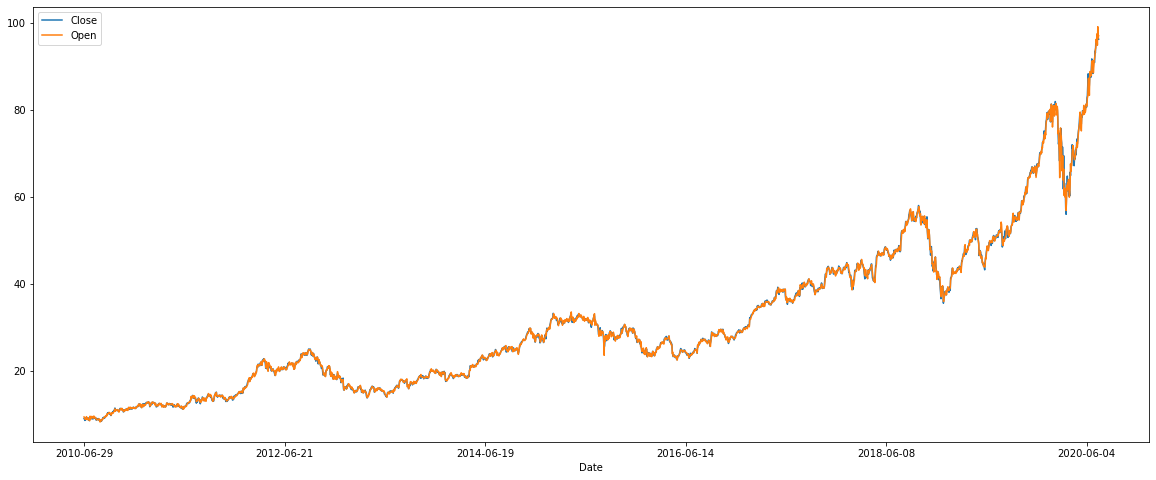

In [5]:
dumb_baseline("1_train")

2_train
***********************************************
RMSE with Open:  0.6939200711181353
RMSE with Open_Shifted:  0.47072516791781915
RMSE with Avg:  0.28157365665744777


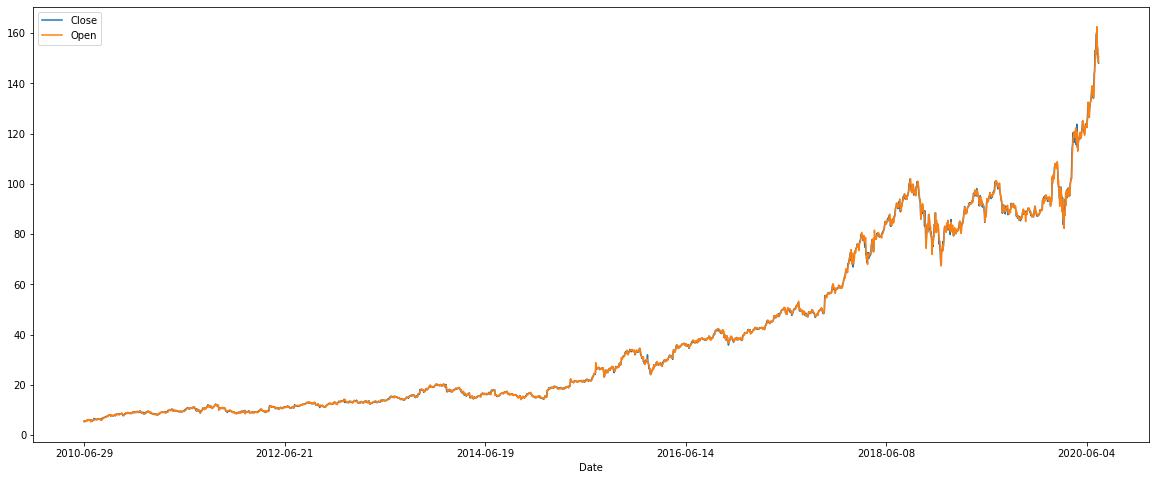

In [6]:
dumb_baseline("2_train")

3_train
***********************************************
RMSE with Open:  0.5857501382852628
RMSE with Open_Shifted:  0.3685747530620308
RMSE with Avg:  0.23440421770051356


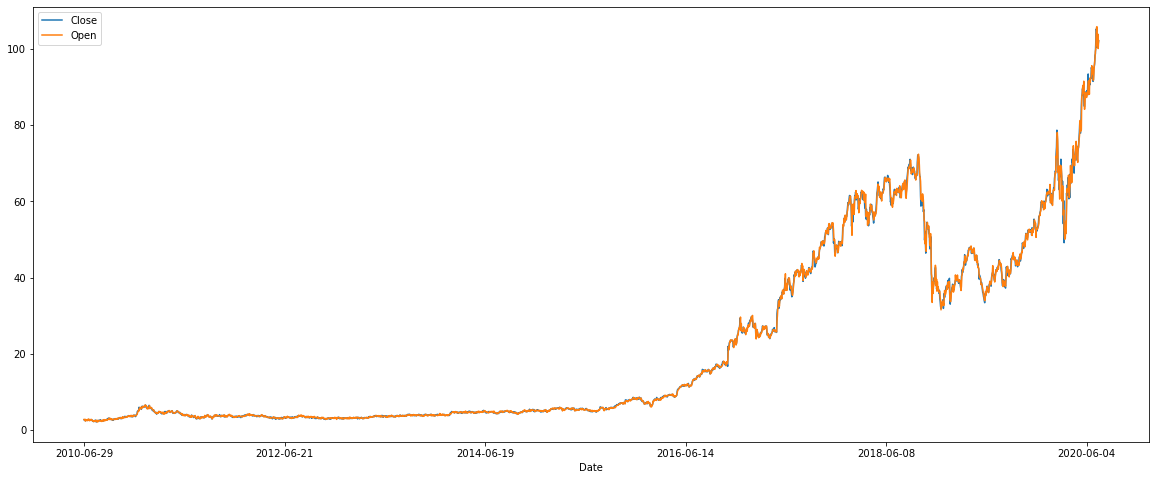

In [7]:
dumb_baseline("3_train")

4_train
***********************************************
RMSE with Open:  0.433692177005136
RMSE with Open_Shifted:  0.3351023310944291
RMSE with Avg:  0.15856778941129987


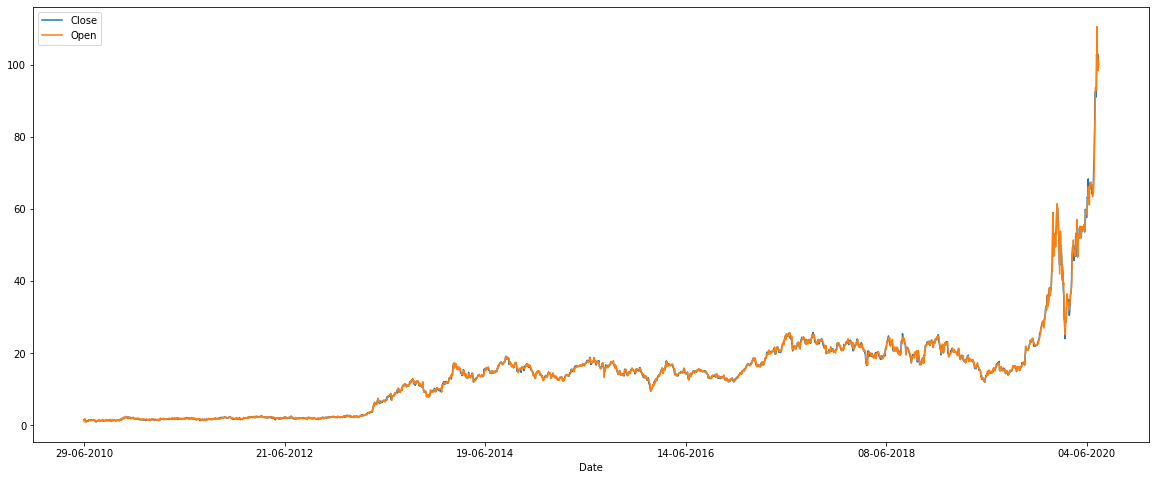

In [8]:
dumb_baseline("4_train")

### LSTM Model

In [9]:
import pandas as pd
import numpy as np
import math
import datetime as dt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle

# ! pip install plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [10]:
train1 = pd.read_csv('/kaggle/input/kaggle-stock-market-prediction/'+'1_train.csv')

In [11]:
train1['Date'] = pd.to_datetime(train1.Date)
train1.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,9.50,9.47,9.23,9.12,7.93,1.133345e+09
1,2010-06-30,9.25,9.22,9.00,9.04,7.52,7.394520e+08
2,2010-07-01,9.01,9.02,8.63,8.70,7.45,1.022896e+09
3,2010-07-02,8.98,8.96,8.74,8.94,7.68,6.938428e+08
4,2010-07-06,9.13,9.13,8.61,8.85,7.68,6.152356e+08


In [12]:
train1.sort_values(by='Date', inplace=True)
train1.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,9.50,9.47,9.23,9.12,7.93,1.133345e+09
1,2010-06-30,9.25,9.22,9.00,9.04,7.52,7.394520e+08
2,2010-07-01,9.01,9.02,8.63,8.70,7.45,1.022896e+09
3,2010-07-02,8.98,8.96,8.74,8.94,7.68,6.938428e+08
4,2010-07-06,9.13,9.13,8.61,8.85,7.68,6.152356e+08


In [13]:
print("Starting date: ",train1.iloc[0][0])
print("Ending date: ", train1.iloc[-1][0])
print("Duration: ", train1.iloc[-1][0]- train1.iloc[0][0])

Starting date:  2010-06-29 00:00:00
Ending date:  2020-07-17 00:00:00
Duration:  3671 days 00:00:00


In [14]:
monthly= train1.groupby(train1['Date'].dt.strftime('%B'))[['Open','Close']].mean().sort_values(by='Close')
monthly.head()

,Open,Close
Date,,
August,28.737623,28.762063
September,29.280197,29.258424
December,30.019713,30.005455
November,30.488878,30.485756
October,30.527818,30.562364


#### August, November and October are the profitable months for this company

In [15]:
from sklearn import preprocessing

In [16]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df = df.reindex(columns = [col for col in df.columns if col != 'Close'] + ['Close'])
    df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
    df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
    df['Volume'] = min_max_scaler.fit_transform(df.Volume.values.reshape(-1,1))
    df['Adj Close'] = min_max_scaler.fit_transform(df['Adj Close'].values.reshape(-1,1))
    df['Close'] = min_max_scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df
train1 = pd.read_csv("/kaggle/input/kaggle-stock-market-prediction/1_train.csv")
train1 = normalize_data(train1)
train1.head()

,Date,Open,High,Low,Adj Close,Volume,Close
0,2010-06-29,0.012895,0.009751,0.010667,0.007415,0.592682,0.007072
1,2010-06-30,0.010140,0.007012,0.008057,0.002809,0.378090,0.006174
2,2010-07-01,0.007495,0.004821,0.003858,0.002022,0.532510,0.002357
3,2010-07-02,0.007164,0.004163,0.005107,0.004606,0.353243,0.005051
4,2010-07-06,0.008817,0.006026,0.003631,0.004606,0.310418,0.004041


In [17]:
train1.drop(['Date'],1,inplace=True)

In [18]:
train1.head()

,Open,High,Low,Adj Close,Volume,Close
0,0.012895,0.009751,0.010667,0.007415,0.592682,0.007072
1,0.010140,0.007012,0.008057,0.002809,0.378090,0.006174
2,0.007495,0.004821,0.003858,0.002022,0.532510,0.002357
3,0.007164,0.004163,0.005107,0.004606,0.353243,0.005051
4,0.008817,0.006026,0.003631,0.004606,0.310418,0.004041


In [19]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) 
    #data = stock.as_matrix() 
    data=stock
    sequence_length = seq_len + 1 
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.85 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [20]:
from keras import backend

In [21]:
def rmse(y_true, y_pred):
 return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [22]:
def build_model(layers):
    d = 0.25
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    #adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=[rmse])
    print("Compilation Time : ", time.time() - start)
    return model

In [23]:
window = 10
X_train1, y_train1, X_test1, y_test1 = load_data(train1, window)
print (X_train1[0], y_train1[0])

[[0.0128954  0.00975129 0.01066727 0.0074149  0.59268165 0.0070715 ]
 [0.01013998 0.00701216 0.00805719 0.00280867 0.37809049 0.00617353]
 [0.00749476 0.00482086 0.00385837 0.00202224 0.5325096  0.00235717]
 [0.00716411 0.00416347 0.00510667 0.00460622 0.35324279 0.00505107]
 [0.00881737 0.00602608 0.00363141 0.00460622 0.31041791 0.00404086]
 [0.00650281 0.00854607 0.00794371 0.00674082 0.3318395  0.00976541]
 [0.01366692 0.0087652  0.00907853 0.00483092 0.37737812 0.00808172]
 [0.00969911 0.0065739  0.00748979 0.00887541 0.21131236 0.00864295]
 [0.00914802 0.00679303 0.00817068 0.00483092 0.28189393 0.00830621]
 [0.01036041 0.00755999 0.00783023 0.00325806 0.62405056 0.00796947]] 0.00505107194971377


In [24]:
test = pd.read_csv('/kaggle/input/kaggle-stock-market-prediction/test.csv')
test.head()

,Date,Open,High,Low,Adj Close,Volume,Company,Id
0,20-07-2020,101.28,110.03,99.24,109.62,256821000,4,0
1,21-07-2020,109.12,111.60,103.88,104.46,241608000,4,1
2,22-07-2020,106.65,108.45,104.05,105.86,212416500,4,2
3,23-07-2020,112.07,112.49,98.92,101.04,364927500,4,3
4,24-07-2020,94.49,97.76,91.17,94.47,290949000,4,4


In [25]:
model = build_model([6,window,1])

2023-02-02 17:33:38.322689: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Compilation Time :  0.008245706558227539


In [26]:
model.fit(X_train1,y_train1,batch_size=128,epochs=100,validation_split=0.1,verbose=10)

Epoch 1/100


2023-02-02 17:33:39.292859: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78/100
Epoch 7

In [27]:
p = model.predict(X_test1)
print (p.shape,y_test1.shape)

(378, 1) (378,)


In [28]:
temp = pd.read_csv("/kaggle/input/kaggle-stock-market-prediction/1_train.csv")
close_real = temp['Close'].values.reshape(-1,1)
p=p.reshape(-1,1)
mm_scaler = preprocessing.MinMaxScaler()
a = mm_scaler.fit_transform(close_real)
preds = mm_scaler.inverse_transform(p)

In [29]:
y_test1= y_test1.reshape(-1,1)
y_test1= mm_scaler.inverse_transform(y_test1)

In [30]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=5)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=5)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, X_train1, y_train1, X_test1, y_test1)

Train Score: 0.00008 MSE (0.01 RMSE)
Test Score: 3913.67456 MSE (62.56 RMSE)


(8.224882185459137e-05, 3913.674560546875)

In [31]:
import matplotlib.pyplot as plt

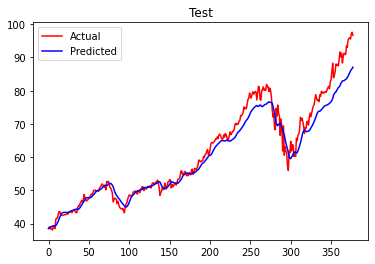

In [32]:
plt.plot(y_test1,color='red', label='Actual')
plt.plot(preds,color='blue', label='Predicted')
plt.title("Test")
plt.legend(loc='best')
plt.show()

In [33]:
# Sanity Check
mean_squared_error(preds, y_test1)**0.5

3.487759715239042

1. Line Plot of data
2. LSTM model
3. Open 